# Open Data in den Bundesministerien

Um die Open-Data-Aktivitäten der Bundesministerien zu analysieren werden die Metadaten von [GovData](https://www.govdata.de/) analysiert. 

Diese Analyse bietet sich an, da Behörden des Bundes nach § 12a E-Government-Gesetz (EGovG) verpflichtet sind, veröffentlichte Daten mit Metadaten zu versehen und diese im nationalen Metadatenportal GovData einzustellen. 

Die auf GovData eingestellten Metadaten können über SPARQL-Abfragen durchsucht werden. SPARQL ist eine Abfragesprache mit der Daten im RDF-Format (Resource Description Framework) abgerufen und bearbeitet werden können. Auf GovData wird ein [SPARQL-Assisent](https://www.govdata.de/web/guest/sparql-assistent) bereitgestellt, der beispielhafte Abfragen aufführt.  

Für die Reproduzierbarkeit der Analyse wurde die Abfrage jedoch nicht mit dem SPARQL-Assistenten, sondern mit dem unten aufgeführten Skript ausgeführt. Über das Metadatenfeld ```dct:publisher``` und über den regulären Ausdruck ```^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*``` wurden die Datensätze der Bundesministerien (+ Bundeskanzleramt) identifiziert. Des Weiteren wurden die Metadatenfelder ```dcat:accessURL``` und ```dct:issued``` abgerufen, um Aussagen über die Verfügbarkeit der Ressourcen, über die Dateiformate und über die zeitliche Entwicklung der Open-Data-Aktivitäten treffen zu können.

In [1]:
import requests
import pandas as pd
import io
import numpy as np

# Define the SPARQL endpoint
endpoint = "https://www.govdata.de/sparql"

# Get the proxy URL
proxy_url = requests.utils.getproxies().get('http')

# Set the proxy configuration
proxies = {'http': proxy_url}

query = """
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcatde: <http://dcat-ap.de/def/dcatde/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?dataset ?title ?publisher_name ?distribution_link ?publication_year
WHERE {
  ?dataset a dcat:Dataset ;
            dct:title ?title ;
            dcat:distribution ?distribution ;
            dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) .
  OPTIONAL { ?distribution dcat:accessURL ?distribution_link } .
  OPTIONAL { ?dataset dct:issued ?publication_date } .
  BIND (year(?publication_date) as ?publication_year)
}
"""

# Send the SPARQL query and get the response in CSV format
url = endpoint + '?query=' + requests.utils.quote(query, safe='')
headers = {'Accept': 'text/csv'}
response = requests.get(url, headers=headers, proxies=proxies, timeout=60)

# Convert the CSV response to a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# Delete unnecessary variables
del endpoint, proxy_url, proxies, query, url, headers, response


In [2]:
import requests
import pandas as pd
import io
import numpy as np

# Define the SPARQL endpoint
endpoint = "https://www.govdata.de/sparql"

# Get the proxy URL
proxy_url = requests.utils.getproxies().get('http')

# Set the proxy configuration
proxies = {'http': proxy_url}

query = """
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcatde: <http://dcat-ap.de/def/dcatde/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?dataset ?title ?publisher_name ?distribution_link ?publication_year ?license ?format
WHERE {
  ?dataset a dcat:Dataset ;
            dct:title ?title ;
            dcat:distribution ?distribution ;
            dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) .
  OPTIONAL { ?distribution dcat:accessURL ?distribution_link } .
  OPTIONAL { ?dataset dct:issued ?publication_date } .
  BIND (year(?publication_date) as ?publication_year) .
  OPTIONAL { ?distribution dct:license ?license } .
  OPTIONAL { ?distribution dct:format ?format }
}
"""

# Send the SPARQL query and get the response in CSV format
url = endpoint + '?query=' + requests.utils.quote(query, safe='')
headers = {'Accept': 'text/csv'}
response = requests.get(url, headers=headers, proxies=proxies, timeout=60)

# Convert the CSV response to a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# Delete unnecessary variables
del endpoint, proxy_url, proxies, query, url, headers, response

In [3]:
# Use np.select to create a new column publisher_short with the short publisher name
conditions = [
    df['publisher_name'].str.contains('Wirtschaft und|BMWK|BMWI', case=False),
    df['publisher_name'].str.contains('Finanzen|^BMF', case=False),
    df['publisher_name'].str.contains('Innern|^BMI', case=False),
    df['publisher_name'].str.contains('^Ausw|^AA', case=False),
    df['publisher_name'].str.contains('Justitz|BMJ', case=False),
    df['publisher_name'].str.contains('Arbeit|BMAS', case=False),
    df['publisher_name'].str.contains('Verteidigung|BMVg', case=False),
    df['publisher_name'].str.contains('Landwirtschaft|BMEL', case=False),
    df['publisher_name'].str.contains('Familie|BMFSFJ', case=False),
    df['publisher_name'].str.contains('Gesundheit|BMG', case=False),
    df['publisher_name'].str.contains('Verkehr|BMDV', case=False),
    df['publisher_name'].str.contains('Umwelt|BMUV', case=False),
    df['publisher_name'].str.contains('Bildung|BMBF', case=False),
    df['publisher_name'].str.contains('Entwicklung|BMZ', case=False),
    df['publisher_name'].str.contains('Wohnen|BMWSB', case=False),
    df['publisher_name'].str.contains('Bundeskanzleramt|BKAmt', case=False)
]

choices = ['BMWK', 'BMF', 'BMI', 'AA', 'BMJ', 'BMAS', 'BMVg', 'BMEL', 'BMFSFJ', 'BMG', 'BMDV', 'BMUV', 'BMBF', 'BMZ', 'BMWSB', 'BKAmt']
df['publisher_short'] = np.select(conditions, choices, default='other')

# Create factor column for the publisher_short column
df['publisher_short'] = pd.Categorical(df['publisher_short'], categories=choices, ordered=True)

# Delete variables that are not needed anymore
del choices, conditions

## Datensätze nach Bundesministerium

In [9]:
# Get only distinct datasets
df_distinct = df.drop_duplicates(subset=['dataset'])

In [10]:
# Count the number of datasets per publisher
df_distinct_publ = df_distinct['publisher_short'].value_counts()

# Make dataframe
# df_distinct_publ = df_distinct_publ.rename_axis('publisher').reset_index(name='count')

# Add the percentages
#df_distinct_publ = df_distinct_publ.to_frame()
#df_distinct_publ['percentage'] = df_distinct_publ['publisher_short'] / df_distinct_publ['publisher_short'].sum()
#df_distinct_publ = df_distinct_publ.round(3)


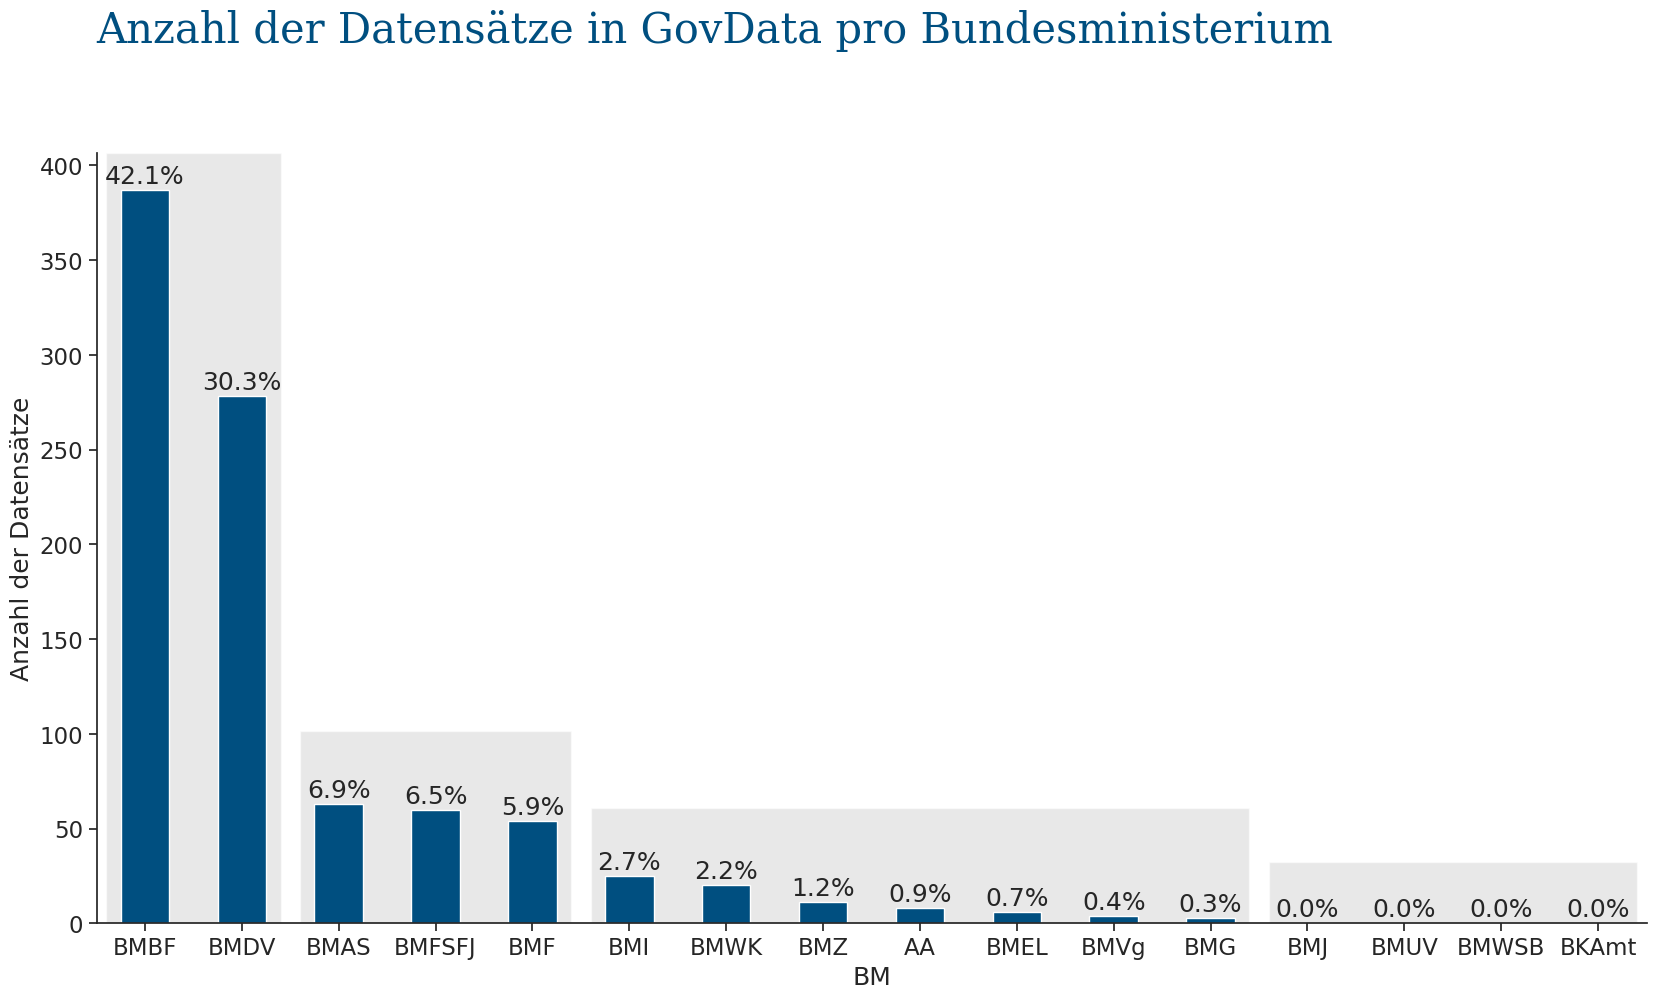

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot df_distinct_publ with Seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
#sns.set_palette("bright")

# Set color of the bars
sns.set_color_codes("pastel")

ax = df_distinct_publ.plot(kind='bar', figsize=(20,10), color='#004F80')

# set font properties and position of title 
title_font = {'size': 30, 'family': 'serif', 'color': '#004F80'}
ax.set_title("Anzahl der Datensätze in GovData pro Bundesministerium", fontdict=title_font, loc='left', pad=80)

# Set the labels
ax.set_xlabel('BM')
ax.set_ylabel('Anzahl der Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_distinct_publ.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

""" # Add rectangle for the first two BMs behind the bars
for p in ax.patches:
    if p.get_x() < 1.4:
        ax.axvspan(p.get_x(), p.get_x() + p.get_width(), facecolor='lightgrey', alpha=0.5)
    else:
        break """


# Add rectangle for the first two BMs
ax.axvspan(-0.4, 1.4, facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.axvspan(1.6, 4.4, ymax=0.25, facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.axvspan(4.6, 11.4, ymax=0.15, facecolor='lightgrey', alpha=0.5, zorder=-1)
ax.axvspan(11.6, 15.4, ymax=0.08, facecolor='lightgrey', alpha=0.5, zorder=-1)

# Show the plot
plt.show()

# Save plot as PNG locally in folder output
plt.savefig('output/Anzahl_Datensaetze_pro_BM.png', bbox_inches='tight', dpi=300)





In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://www.govdata.de/sparql")
query = """
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT (COUNT(?dataset) AS ?datasets) 
WHERE {
  ?dataset a dcat:Dataset .
  ?dataset dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(!REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) 
}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Extract the number of datasets from the JSON response
n_datasets_all = results['results']['bindings'][0]['datasets']['value']
n_datasets_all = int(n_datasets_all)

from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("https://www.govdata.de/sparql")
query = """
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT (COUNT(?dataset) AS ?datasets) 
WHERE {
  ?dataset a dcat:Dataset .
  ?dataset dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$|^bundeskanzl.*|^bkamt.*')) 
}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Extract the number of datasets from the JSON response as integer
n_datasets_bm = results['results']['bindings'][0]['datasets']['value']
n_datasets_bm = int(n_datasets_bm)

# Calculate the percentage of datasets from BMs
percentage_bm = n_datasets_bm / n_datasets_all *100


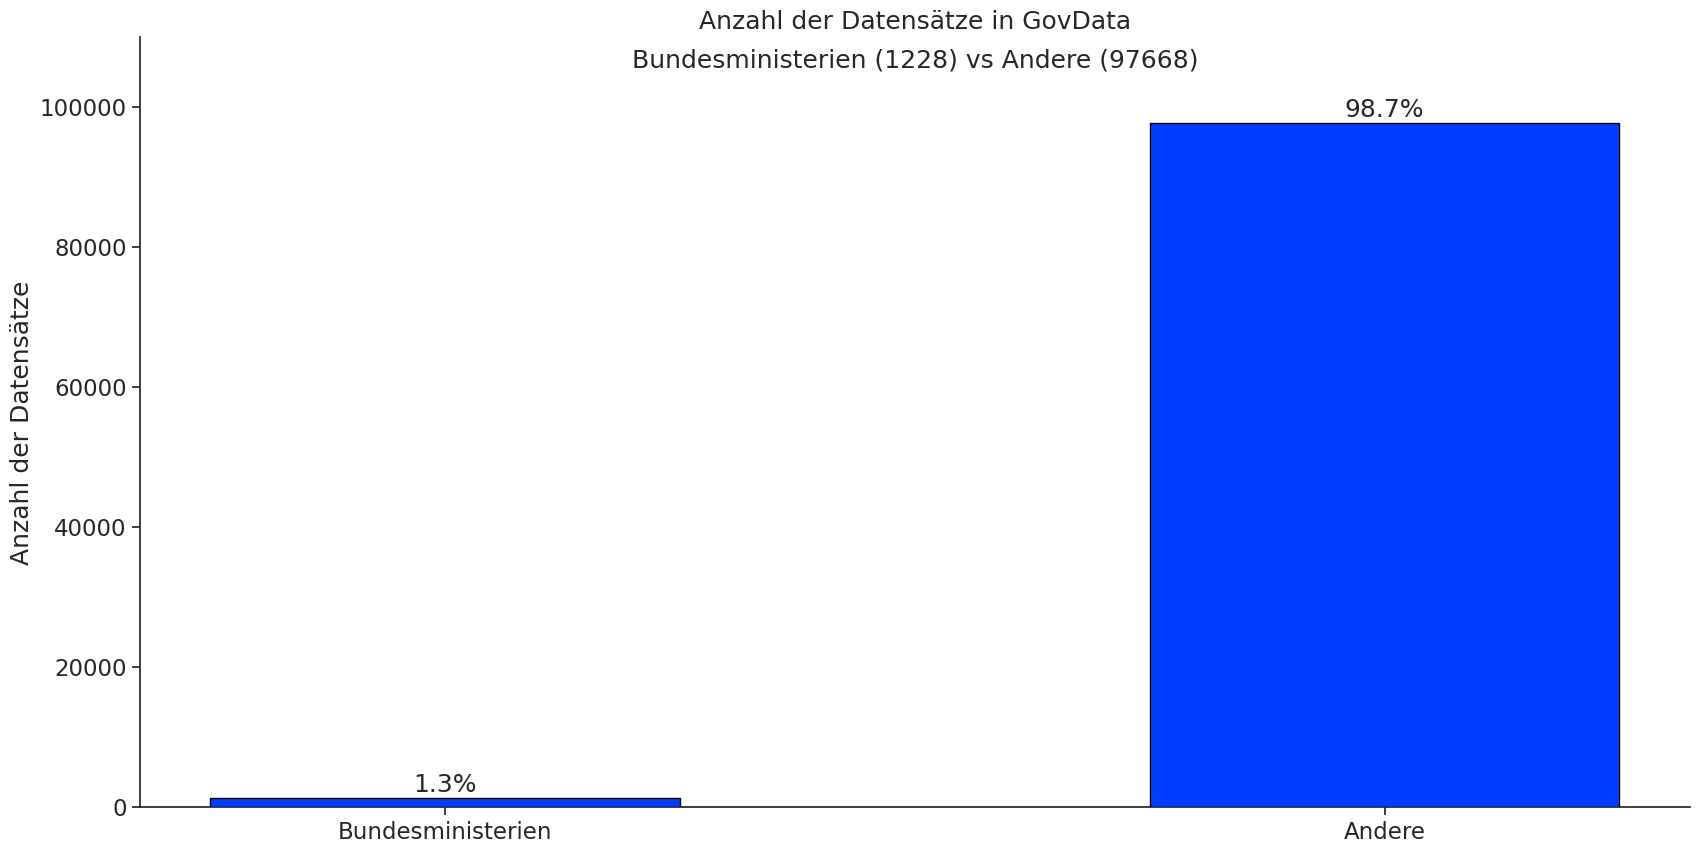

In [15]:
# Bar chart of n_datasets_all and n_datasets_bm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Create the figure
fig, ax = plt.subplots(figsize=(20,10))

# Set the title
ax.set_title('Anzahl der Datensätze in GovData')

# Set subtitle
ax.text(0.5, 0.97, 'Bundesministerien (' + str(n_datasets_bm) + ') vs Andere (' + str(n_datasets_all) + ')', ha='center', va='center', transform=ax.transAxes)

# Set the labels
ax.set_xlabel('')
ax.set_ylabel('Anzahl der Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Set the x-axis labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Bundesministerien', 'Andere'])

# Set ylimit
ax.set_ylim(0, 110000)

# Set the y-axis labels
ax.set_yticks(np.arange(0, 100001, 20000))
ax.set_yticklabels(np.arange(0, 100001, 20000))

# Set the bar width
bar_width = 0.5

# Plot the bars
ax.bar(0, n_datasets_bm, width=bar_width, color='#023eff', edgecolor='black', zorder=3)
ax.bar(1, n_datasets_all, width=bar_width, color='#023eff', edgecolor='black', zorder=3)

# Add the percentages
ax.annotate('{:.1f}%'.format(percentage_bm), (0, n_datasets_bm), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.annotate('{:.1f}%'.format(100 - percentage_bm), (1, n_datasets_all), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


In [5]:
# Subset the file format from the distribution_link column
df['file_format'] = df['distribution_link'].str.split('.').str[-1]

# Change all values in file_column to 'csv' that contain '.csv' and all to 'json' that contain '.json'
df.loc[df['distribution_link'].str.contains('csv', case=False), 'file_format'] = 'csv'
df.loc[df['distribution_link'].str.contains('json', case=False), 'file_format'] = 'json'
df.loc[df['distribution_link'].str.contains('pdf', case=False), 'file_format'] = 'pdf'
df.loc[df['distribution_link'].str.contains('xlsx', case=False), 'file_format'] = 'xlsx'
df.loc[df['distribution_link'].str.contains('xls[^x]', case=False), 'file_format'] = 'xls'
df.loc[df['distribution_link'].str.contains('xlm', case=False), 'file_format'] = 'xlm'

# Change all values in file_column to 'other' that are longer than 4 characters
df.loc[df['file_format'].str.len() > 5, 'file_format'] = 'other link'

# Change all values in file_column to 'other' that are "html"
df.loc[df['file_format'] == 'html', 'file_format'] = 'other link'

# Count number of occurences and change all to 'other' that occur fewer than 5 times
df['file_format'] = df['file_format'].where(df['file_format'].map(df['file_format'].value_counts()) > 5, 'other link')


# Export df to CSV
#df.to_csv('output/govdata.csv', index=False)

In [6]:
# Count number of occurences in file_format 
df_file_format = df['file_format'].value_counts()
print(df_file_format)



other link    1073
csv            515
pdf            405
xls            347
xml            168
xlsx            73
zip             12
txt              7
json             6
Name: file_format, dtype: int64


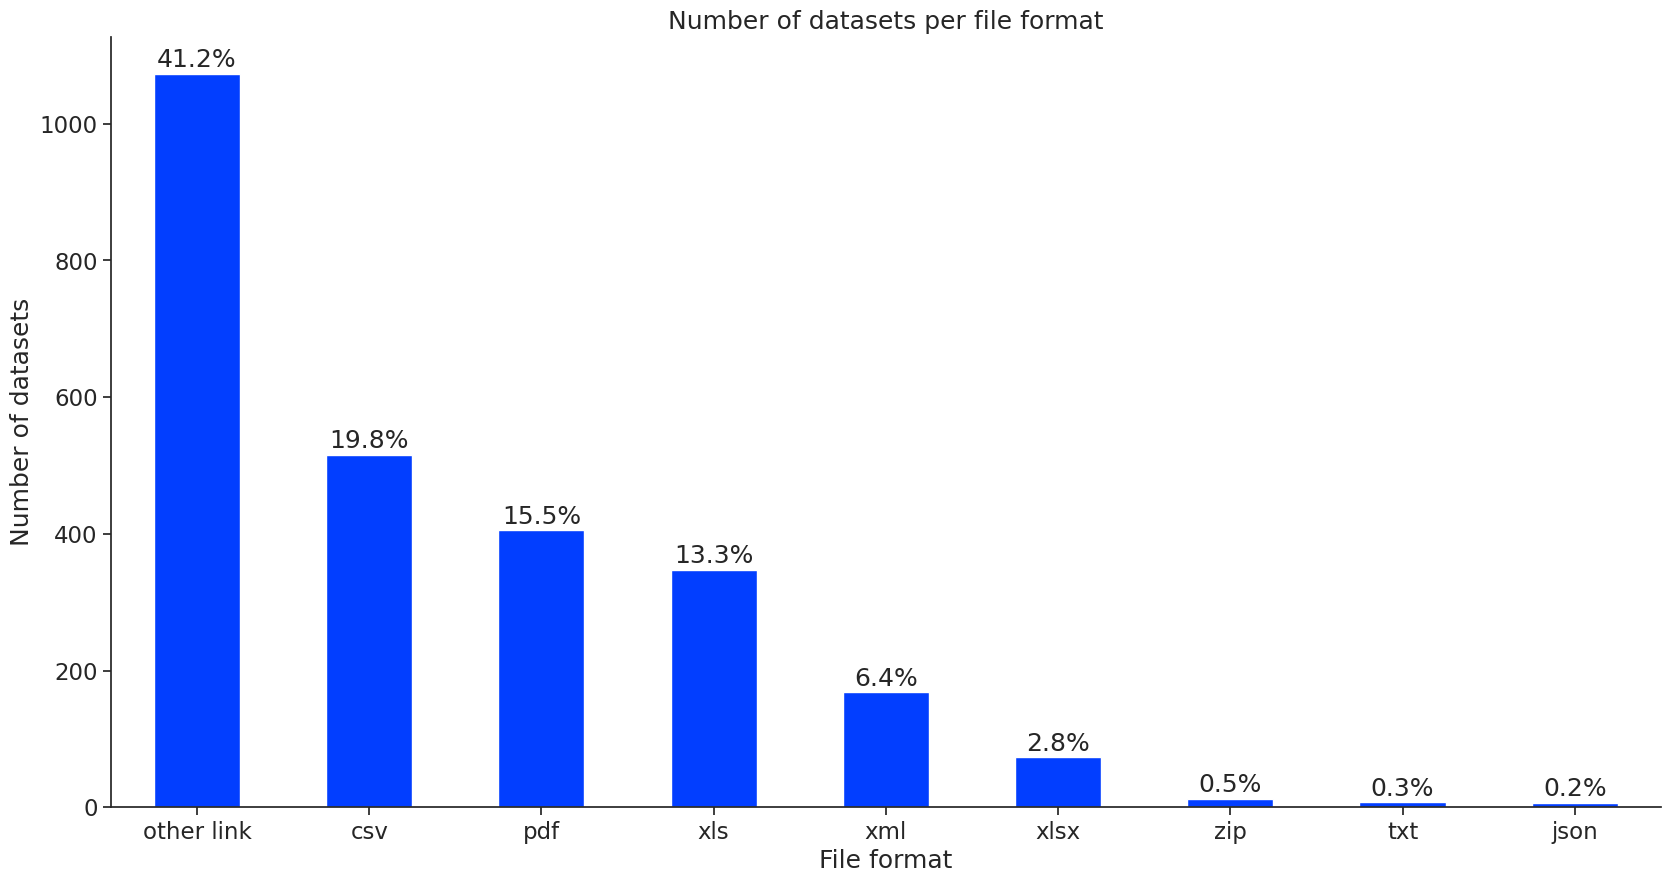

In [7]:
# Plot df_file_format
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")

# Create the plot
ax = df_file_format.plot(kind='bar', figsize=(20,10), title='Number of datasets per file format')

# Set the labels
ax.set_xlabel('File format')
ax.set_ylabel('Number of datasets')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_file_format.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


In [37]:
# Count the number of datasets per publisher and publication_year
df_year_publisher = df_distinct.groupby(['publisher_short', 'publication_year']).size().reset_index(name='n_datasets')

# Change publication_year to integer
df_year_publisher['publication_year'] = df_year_publisher['publication_year'].astype(int)

# Sort the values by publication_year
df_year_publisher = df_year_publisher.sort_values(by=['publication_year'])

# Change the index to publication_year
#df_year_publisher = df_year_publisher.set_index('publication_year')

print(df_year_publisher)

    publisher_short  publication_year  n_datasets
0              BMWK              2009           0
105            BMEL              2009           0
60              BMJ              2009           0
45               AA              2009           0
180            BMBF              2009           0
..              ...               ...         ...
44              BMI              2023           0
29              BMF              2023           0
14             BMWK              2023           0
224           BMWSB              2023           0
239           BKAmt              2023           0

[240 rows x 3 columns]


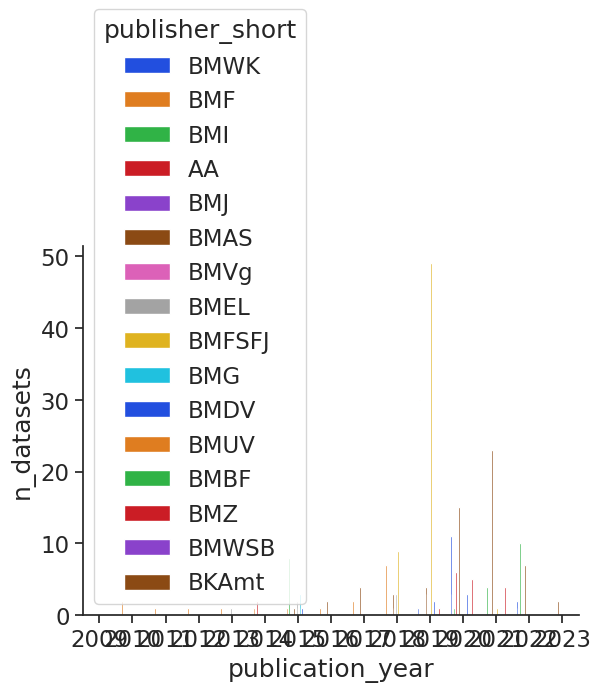

In [44]:
# Plot df_year_publisher as stacked bar chart
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")

# Create the stacked bar plot
sns.barplot(x='publication_year', y='n_datasets', hue='publisher_short', data=df_year_publisher, palette='bright')


#ax = df_year_publisher.plot(kind='bar', figsize=(20,10), title='Number of datasets per publisher and year', x='publication_year', hue = "publisher_short", stacked=True)

# Set the labels
#ax.set_xlabel('Year')
#ax.set_ylabel('Number of datasets')

# Set the x-axis labels to horizontal
#ax.tick_params(axis='x', labelrotation=0)

# Show the plot
plt.show()




In [53]:
# Count the number of datasets per year
df_distinct_year = df_distinct['publication_year'].value_counts()

# Rename the column
#df_distinct_year = df_distinct_year.rename_axis('year').reset_index(name='count')

# Set the index to the year
#df_distinct_year = df_distinct_year.set_index('year')

# Change year to integer
df_distinct_year.index = df_distinct_year.index.astype(int)

# Change year to datetime
# df_distinct_year.index = pd.to_datetime(df_distinct_year.index, format='%Y')

# Sort the index
df_distinct_year = df_distinct_year.sort_index()

# Print the result
print(df_distinct_year)

2009     2
2010     2
2011     1
2012     1
2013     2
2014     7
2015    22
2016     3
2017     6
2018    24
2019    90
2020    44
2021    35
2022    20
2023     2
Name: publication_year, dtype: int64


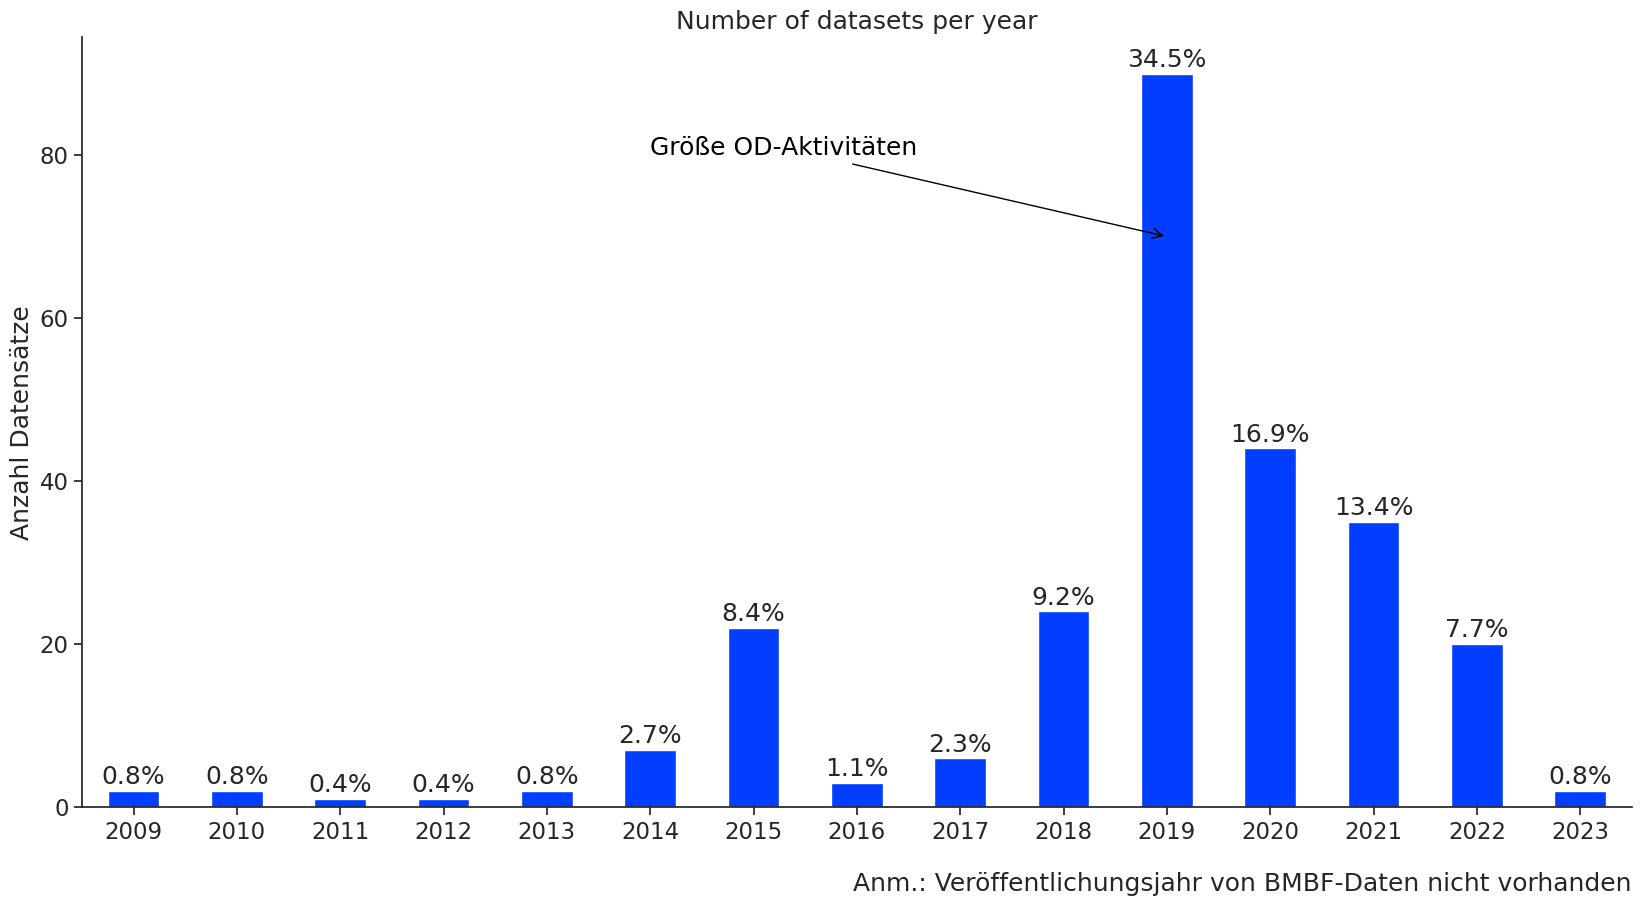

In [57]:
# Plot df_distinct_year
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")

# Create the plot
ax = df_distinct_year.plot(kind='bar', figsize=(20,10), title='Number of datasets per year')

# Set the labels
ax.set_xlabel('')
ax.set_ylabel('Anzahl Datensätze')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / df_distinct_year.sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add caption
ax.text(1, -0.1, 'Anm.: Veröffentlichungsjahr von BMBF-Daten nicht vorhanden', ha='right', va='center', transform=ax.transAxes)

# Add annotation for 2019 in color black with Text "Größe OD-Aktivitäten"
ax.annotate('Größte OD-Aktivitäten', xy=(10, 70), xytext=(5, 80), xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color = 'black'), color='black')

# Show the plot
plt.show()


TypeError: Path.__init__() missing 1 required positional argument: 'vertices'

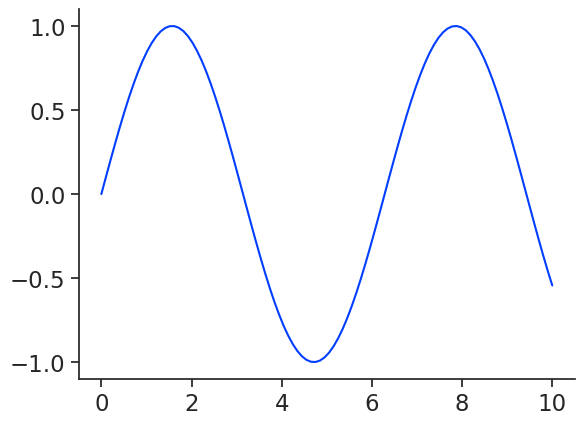

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import FancyArrowPatch

# Generate sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a Seaborn plot
sns.lineplot(x=x, y=y)

# Define the curve for the arrow
path = Path()

#verts = [(5, np.sin(5)), (6, np.sin(7)), (7, np.sin(7))]
verts = [(2.5, 0), (3, 0.5), (3.5, 1)]
path = Path(verts)

# Create a curved arrow with a curved line using Matplotlib
arrow = FancyArrowPatch(
    path=path,
    arrowstyle="-|>,head_width=0.5,head_length=0.8",
    lw=3,
    color='r'
)

# Add the arrow to the plot
ax = plt.gca()
ax.add_patch(arrow)

# Show the plot
plt.show()

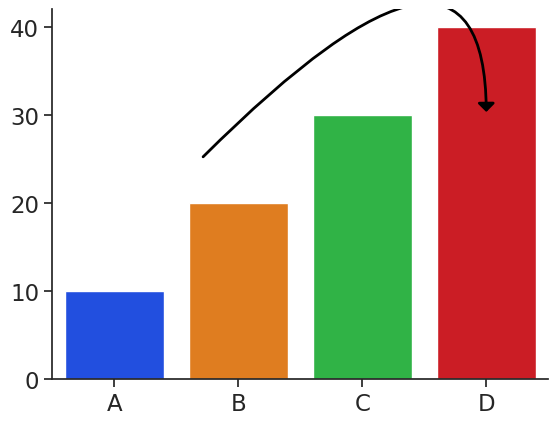

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import FancyArrowPatch

# Generate sample data
x = ['A', 'B', 'C', 'D']
y = [10, 20, 30, 40]

# Create a Seaborn bar plot
sns.barplot(x=x, y=y)

# Define the curve for the arrow
verts = [(0.5, 15), (0.2, 30), (0.3, 35), (3, 40)]
path = Path(verts)

# Create a curved arrow with a curved line using Matplotlib
arrow = FancyArrowPatch(
    #path=path,
    posA = (0.7, 25),
    posB = (3, 30),
    arrowstyle="-|>,head_width=5,head_length=5",
    connectionstyle="angle3,angleA=45,angleB=90",
    lw=2,
    color='black'
)

# Add the arrow to the plot
ax = plt.gca()
ax.add_patch(arrow)

# Show the plot
plt.show()


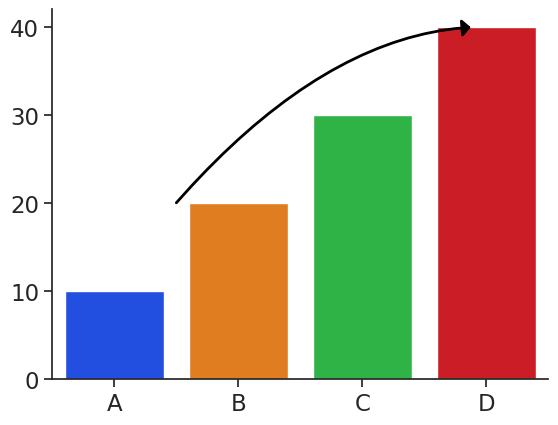

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import FancyArrowPatch

# Generate sample data
x = ['A', 'B', 'C', 'D']
y = [10, 20, 30, 40]

# Create a Seaborn bar plot
sns.barplot(x=x, y=y)

# Define the curve for the arrow
n_curves = 20
x0, y0 = 0.5, 20
x1, y1 = 3, 40
dx = (x1 - x0) / n_curves
verts = [(x0 + i * dx, y0 + (y1 - y0) * (2 * (i / n_curves) - (i / n_curves) ** 2)) for i in range(n_curves)]
path = Path(verts)

# Create a curved arrow with a curved line using Matplotlib
arrow = FancyArrowPatch(
    path=path,
    arrowstyle="-|>,head_width=5,head_length=5",
    lw=2,
    color='black'
)

# Add the arrow to the plot
ax = plt.gca()
ax.add_patch(arrow)

# Show the plot
plt.show()


In [44]:
random_rows = df.sample(n=30)

In [ ]:
""" import requests

# List of URLs to check
# urls = random_rows.distribution_link
urls = df.distribution_link
# Create a list of dictionaries to store the results
results = []

# Check the status of each URL and store the result in the list of dictionaries
for url in urls:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            status = "OK"
        else:
            status = f"Error {response.status_code}"
    except requests.exceptions.RequestException as e:
        status = f"Error {e}"
    results.append({"url": url, "status": status})

# Create a DataFrame from the list of dictionaries
results_url_status = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

# Print the DataFrame
print(results_url_status)

# Delete variables that are not needed anymore
del results, response, url, urls """

In [54]:
# Save the df results_url_status to a CSV file with actual date in the filename

from datetime import datetime
results_url_status.to_csv(f"output/results_url_status_{datetime.now().strftime('%Y%m%d')}.csv", index=False)

In [49]:
# Save the results_url_status to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

In [59]:
# Load the results_url_status from a CSV file
results_url_status = pd.read_csv("output/results_url_status.csv")

(results_url_status["status"] == "OK").sum()

2474

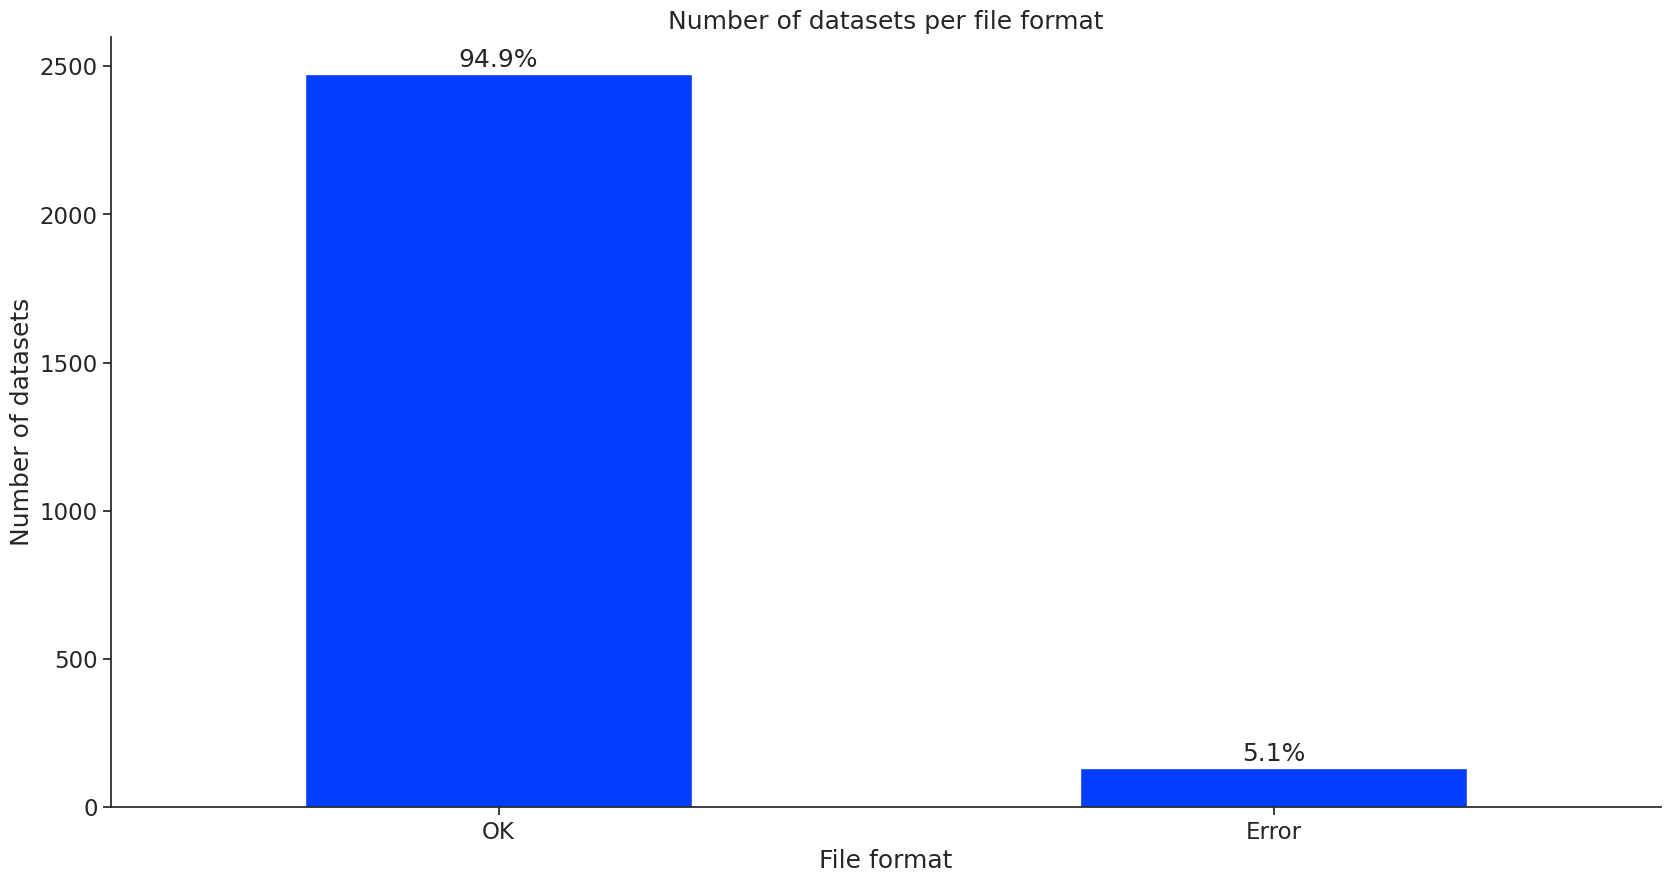

In [62]:
# Plot results_url_status with Seaborn

# Set the font scale
sns.set(font_scale=1.5)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.5)

# Set the color palette
sns.set_palette("bright")
# Create the plot
ax = results_url_status['status'].value_counts().plot(kind='bar', figsize=(20,10), title='Number of datasets per file format')

# Set the labels
ax.set_xlabel('File format')
ax.set_ylabel('Number of datasets')

# Set the x-axis labels to horizontal
ax.tick_params(axis='x', labelrotation=0)

# Add the percentages
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / results_url_status['status'].value_counts().sum()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()
